In [ ]:
!pip install chardet
!pip install -U sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import transformers
import random
import chardet
import warnings
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def random_seed(SEED):

    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

SEED = 508
random_seed(SEED)

In [ ]:
import pandas as pd

# Corrected Google Drive direct download link
data=pd.read_csv('https://drive.google.com/uc?export=download&id=1bm32nrmEkfmNakLl3UA4MAyrEjaGXrUC')
data=data[['text_fr','labels']]
data.columns=['text','targets']
display(data)
class_names=sorted(data['targets'].unique().tolist())
print(class_names)
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))

,text,targets
0,"Allez jusqu'à Jurong point, fou.. Disponible s...",ham
1,J'ai fait une blague sur le wif u oni...,ham
2,Entrée libre dans 2 a wkly comp pour gagner FA...,spam
3,U dun dit si tôt hor... U c déjà dire alors...,ham
4,"Non, je ne pense pas qu'il va à usf, il vit da...",ham
...,...,...
5567,C'est la 2ème fois que nous avons essayé 2 con...,spam
5568,Est-ce que ü b ira à l'esplanade en maison?,ham
5569,"Dommage, * était d'humeur pour ça. Donc... d'a...",ham
5570,Le type a fait une saloperie mais j'ai agi com...,ham


['ham', 'spam']


In [ ]:
nltk.download('stopwords')
Stopwords = stopwords.words('french')
print(Stopwords)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_process(message):
  nopunc = [char for char in message if char not in string.punctuation]
  nopunc = ''.join(nopunc)
  return [word for word in nopunc.split() if word.lower() not in stopwords.words('french')]

message = "Coucouc! les Zamis. Voilà ...."
print(text_process(message))


['Coucouc', 'Zamis', 'Voilà']


In [ ]:


bow_transformer = CountVectorizer(analyzer=text_process)
messages_bow = bow_transformer.fit_transform(data['text'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 12370)
Amount of Non-Zero occurences:  53562


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(messages_bow, data['targets'], test_size=0.2, random_state=42)
spam_detect_model = MultinomialNB()
spam_detect_model.fit(X_train, y_train)

MultinomialNB()

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       966
        spam       0.89      0.93      0.91       149

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115



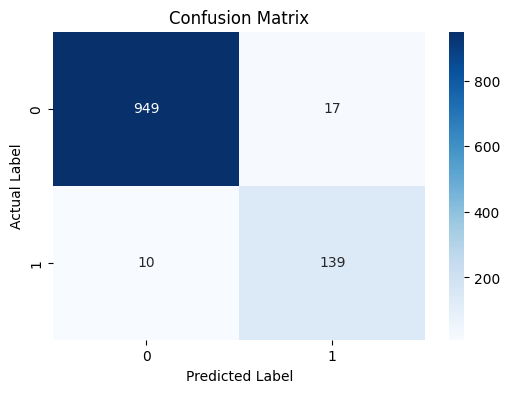

In [ ]:
predictions = spam_detect_model.predict(X_test)
print(classification_report(y_test, predictions))
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Shape of Sparse Matrix (with bigrams):  (5572, 46576)
Amount of Non-Zero occurences (with bigrams):  103057
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.85      0.94      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115



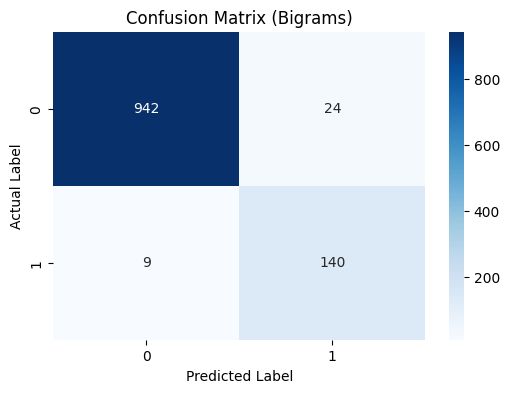

Test message: 'Veuillez appeler immédiatement le 08712402779 car un message urgent vous attend.'
Prediction (with bigrams): spam
Test message: 'SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE.'
Prediction (with bigrams): ham


In [ ]:
def custom_tokenizer(text):
    clean_words = text_process(text)
    return clean_words

bow_transformer_bigram = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2))
messages_bow_bigram = bow_transformer_bigram.fit_transform(data['text'])

print('Shape of Sparse Matrix (with bigrams): ', messages_bow_bigram.shape)
print('Amount of Non-Zero occurences (with bigrams): ', messages_bow_bigram.nnz)

X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(
    messages_bow_bigram, data['targets'], test_size=0.2, random_state=42
)

spam_detect_model_bigram = MultinomialNB()

spam_detect_model_bigram.fit(X_train_bigram, y_train_bigram)

predictions_bigram = spam_detect_model_bigram.predict(X_test_bigram)

print(classification_report(y_test_bigram, predictions_bigram))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_bigram, predictions_bigram), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Bigrams)')
plt.show()

input_message_test = ["Veuillez appeler immédiatement le 08712402779 car un message urgent vous attend."]
input_message_test_vector = bow_transformer_bigram.transform(input_message_test)
prediction_test = spam_detect_model_bigram.predict(input_message_test_vector)
print(f"Test message: '{input_message_test[0]}'")
print(f"Prediction (with bigrams): {prediction_test[0]}")

input_message_test_2 = ["SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE."]
input_message_test_vector_2 = bow_transformer_bigram.transform(input_message_test_2)
prediction_test_2 = spam_detect_model_bigram.predict(input_message_test_vector_2)
print(f"Test message: '{input_message_test_2[0]}'")
print(f"Prediction (with bigrams): {prediction_test_2[0]}")

In [ ]:

spam_detect_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
spam_detect_model_rf.fit(X_train_bigram, y_train_bigram)


feature_names_rf = bow_transformer_bigram.get_feature_names_out()


feature_importance_df = pd.DataFrame({
    'feature': feature_names_rf,
    'importance': spam_detect_model_rf.feature_importances_
})

top_features_rf = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

print("\n--- Top 20 Most Important Features (Random Forest) ---")
display(top_features_rf)


--- Top 20 Most Important Features (Random Forest) ---


,feature,importance
4428,appelez,0.039025
41942,txt,0.017263
18612,gratuit,0.015815
38986,stop,0.013325
37250,service,0.010777
26420,mobile,0.010716
32740,prix,0.008689
35874,réclamer,0.008146
40322,texte,0.007378
24698,maintenant,0.006558


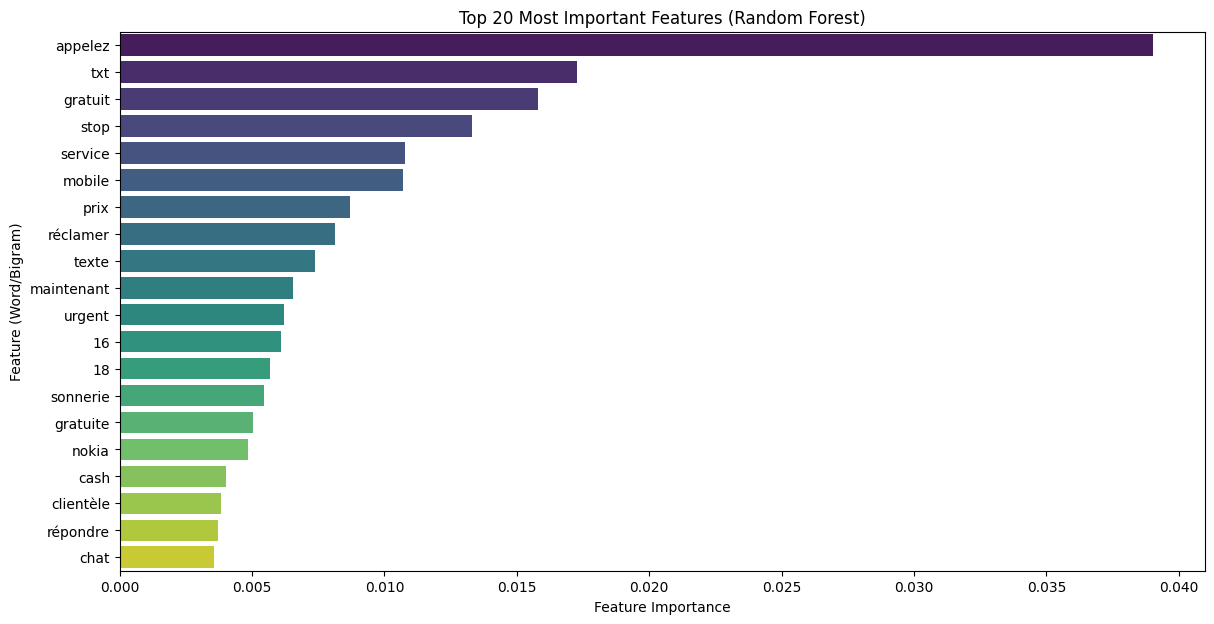

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(x='importance', y='feature', data=top_features_rf, palette='viridis', legend=False)
plt.title('Top 20 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature (Word/Bigram)')
plt.show()

In [ ]:
spam_detect_model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
spam_detect_model_rf.fit(X_train_bigram, y_train_bigram)

RandomForestClassifier(class_weight='balanced', random_state=42)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



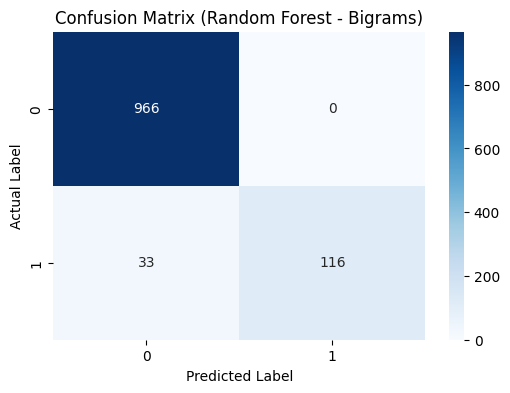

In [ ]:
predictions_rf = spam_detect_model_rf.predict(X_test_bigram)

print(classification_report(y_test_bigram, predictions_rf))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_bigram, predictions_rf), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Random Forest - Bigrams)')
plt.show()

In [ ]:
input_message_rf_1 = ["Veuillez appeler immédiatement le 08712402779 car un message urgent vous attend.."]
input_vector_rf_1 = bow_transformer_bigram.transform(input_message_rf_1)
prediction_rf_1 = spam_detect_model_rf.predict(input_vector_rf_1)
print(f"Test message: '{input_message_rf_1[0]}'")
print(f"Prediction (Random Forest): {prediction_rf_1[0]}")

input_message_rf_2 = ["SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE."]
input_vector_rf_2 = bow_transformer_bigram.transform(input_message_rf_2)
prediction_rf_2 = spam_detect_model_rf.predict(input_vector_rf_2)
print(f"Test message: '{input_message_rf_2[0]}'")
print(f"Prediction (Random Forest): {prediction_rf_2[0]}")

Test message: 'Veuillez appeler immédiatement le 08712402779 car un message urgent vous attend..'
Prediction (Random Forest): ham
Test message: 'SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE.'
Prediction (Random Forest): ham


In [ ]:
feature_names = bow_transformer_bigram.get_feature_names_out()
ham_prob = spam_detect_model_bigram.feature_log_prob_[0]
spam_prob = spam_detect_model_bigram.feature_log_prob_[1]


features_df = pd.DataFrame({
    'feature': feature_names,
    'ham_log_prob': ham_prob,
    'spam_log_prob': spam_prob
})

features_df['log_prob_diff'] = features_df['spam_log_prob'] - features_df['ham_log_prob']

top_spam_features = features_df.sort_values(by='log_prob_diff', ascending=False).head(20)

top_ham_features = features_df.sort_values(by='log_prob_diff', ascending=True).head(20)

print("\n--- Top 20 features most indicative of SPAM ---")
display(top_spam_features[['feature', 'log_prob_diff']])

print("\n--- Top 20 features most indicative of HAM ---")
display(top_ham_features[['feature', 'log_prob_diff']])


--- Top 20 features most indicative of SPAM ---


,feature,log_prob_diff
4428,appelez,4.520287
42854,urgent,4.339148
7951,cash,4.152562
35874,réclamer,4.152562
38986,stop,4.099918
35854,réclamation,3.856296
45786,£1000,3.821205
45841,£2000,3.784837
836,150ppm,3.747097
7240,box,3.747097



--- Top 20 features most indicative of HAM ---


,feature,log_prob_diff
24004,ltgt,-4.876976
45973,ça,-4.799267
43153,vais,-4.640899
31045,peux,-4.370812
46461,ü,-4.281684
31741,plus tard,-4.164960
9129,chose,-4.135973
8207,cest bon,-3.965347
41809,très,-3.941817
23819,lor,-3.941817


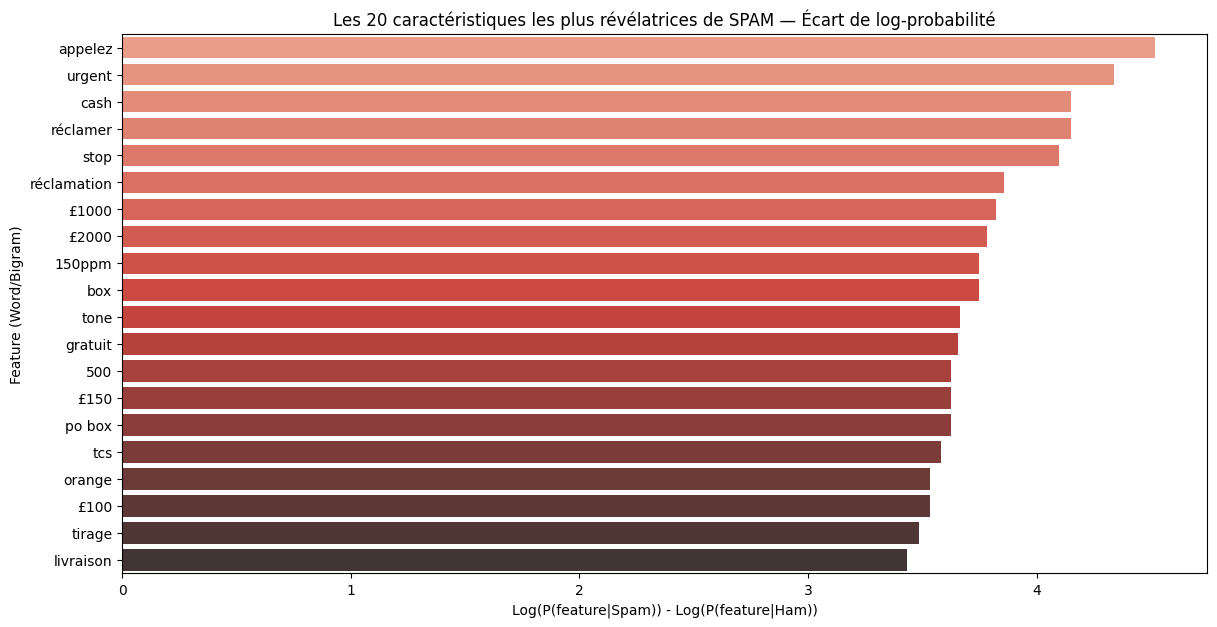

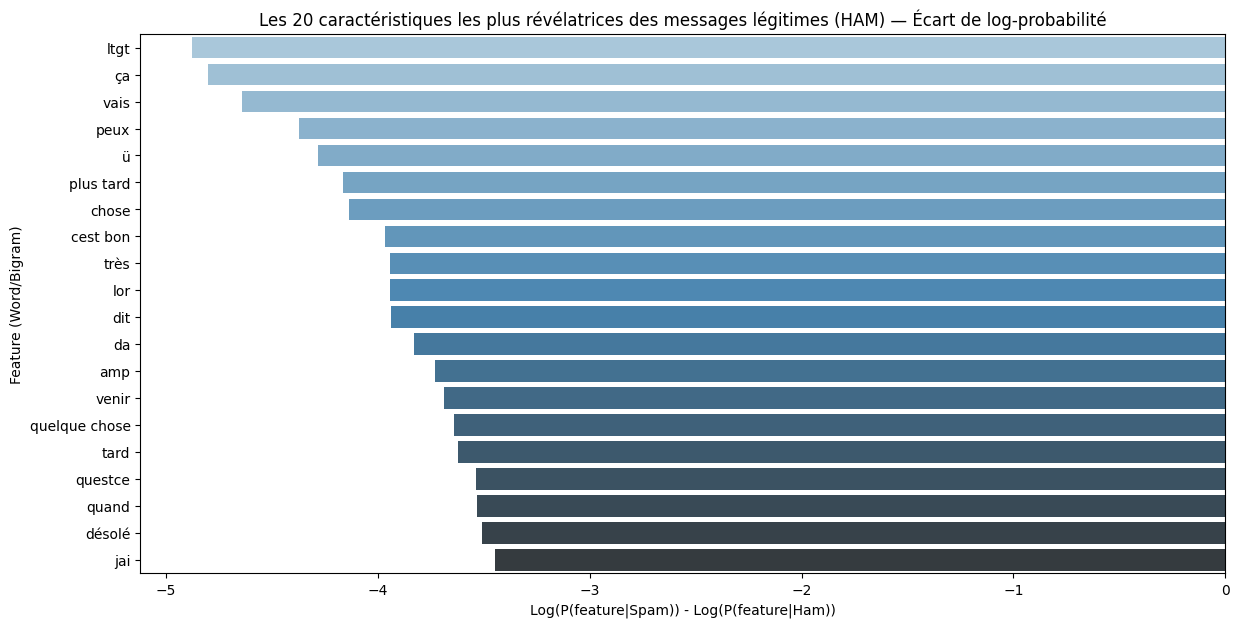

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(x='log_prob_diff', y='feature', data=top_spam_features, palette='Reds_d', legend=False)
plt.title('Les 20 caractéristiques les plus révélatrices de SPAM — Écart de log-probabilité')
plt.xlabel('Log(P(feature|Spam)) - Log(P(feature|Ham))')
plt.ylabel('Feature (Word/Bigram)')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='log_prob_diff', y='feature', data=top_ham_features, palette='Blues_d', legend=False)
plt.title('Les 20 caractéristiques les plus révélatrices des messages légitimes (HAM) — Écart de log-probabilité')
plt.xlabel('Log(P(feature|Spam)) - Log(P(feature|Ham))')
plt.ylabel('Feature (Word/Bigram)')
plt.show()


              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       966
        spam       0.90      0.87      0.88       149

    accuracy                           0.97      1115
   macro avg       0.94      0.93      0.93      1115
weighted avg       0.97      0.97      0.97      1115



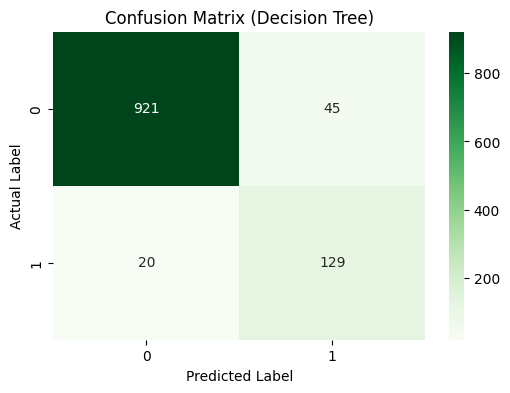

In [ ]:
#Initialisation du modèle arbre de decision
#on fixe souvent une profondeur pour éviter
spam_detect_model_dt = DecisionTreeClassifier(random_state=42)

#Entraînement du modèle
spam_detect_model_dt.fit(X_train_bigram, y_train_bigram)

#Prédictions
predictions_dt = spam_detect_model_dt.predict(X_test_bigram)

#Vérification des résultats
print(classification_report(y_test_bigram, predictions_dt))
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_bigram, predictions_rf), annot=True, fmt='d', cmap='Greens')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

Shape of Sparse Matrix (with bigrams):  (5572, 46576)
Amount of Non-Zero occurrences (with bigrams):  103057

--- Evaluation with Decision Tree ---
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       966
        spam       0.90      0.87      0.88       149

    accuracy                           0.97      1115
   macro avg       0.94      0.93      0.93      1115
weighted avg       0.97      0.97      0.97      1115



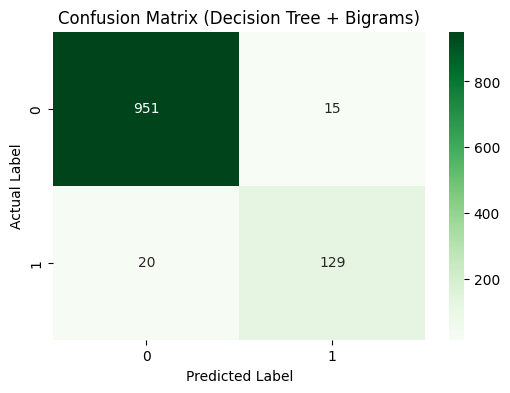

Message: 'La sonnerie Nokia numéro 1 pour votre mobile chaque semaine ! Envoyez NOK par SMS au 87021. Première sonnerie GRATUITE ! Alors, envoyez vos SMS dès maintenant et parlez-en à vos amis. 150 p/sonnerie. 16 réponses HL 4info'
Prediction: spam

Message: 'SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE.'
Prediction: ham



In [ ]:
# 1. Vectorisation (Bigrammes)
bow_transformer_bigram = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2))
messages_bow_bigram = bow_transformer_bigram.fit_transform(data['text'])

print('Shape of Sparse Matrix (with bigrams): ', messages_bow_bigram.shape)
print('Amount of Non-Zero occurrences (with bigrams): ', messages_bow_bigram.nnz)

# 2. Split Train/Test
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(
    messages_bow_bigram, data['targets'], test_size=0.2, random_state=42
)

# 3. Utilisation de l'Arbre de Décision (Remplacement de MultinomialNB)
spam_detect_model_dt = DecisionTreeClassifier(random_state=42)
spam_detect_model_dt.fit(X_train_bigram, y_train_bigram)

# 4. Prédictions
predictions_dt = spam_detect_model_dt.predict(X_test_bigram)

# 5. Évaluation
print("\n--- Evaluation with Decision Tree ---")
print(classification_report(y_test_bigram, predictions_dt))

# 6. Matrice de Confusion
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_bigram, predictions_dt), annot=True, fmt='d', cmap='Greens') # Changé en vert pour DT
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Decision Tree + Bigrams)')
plt.show()

# 7. Tests sur messages spécifiques
def test_message(msg):
    vec = bow_transformer_bigram.transform([msg])
    pred = spam_detect_model_dt.predict(vec)
    print(f"Message: '{msg}'")
    print(f"Prediction: {pred[0]}\n")

test_message("La sonnerie Nokia numéro 1 pour votre mobile chaque semaine ! Envoyez NOK par SMS au 87021. Première sonnerie GRATUITE ! Alors, envoyez vos SMS dès maintenant et parlez-en à vos amis. 150 p/sonnerie. 16 réponses HL 4info")
test_message("SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE.")

In [ ]:
#Initialisation et entraînement du Decision Tree

spam_detect_model_dt = DecisionTreeClassifier(random_state=42)
spam_detect_model_dt.fit(X_train_bigram, y_train_bigram)

# Récupération des noms de features
feature_names_dt = bow_transformer_bigram.get_feature_names_out()

#Création du DataFrame d'importance
# L'attribut .feature_importances_ existe aussi pour l'arbre seul
feature_importance_df = pd.DataFrame({
    'feature': feature_names_dt,
    'importance': spam_detect_model_dt.feature_importances_
})

#Tri et affichage du top 20
top_features_dt = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

print("\n--- Top 20 Most Important Features (Decision Tree) ---")
display(top_features_dt)


--- Top 20 Most Important Features (Decision Tree) ---


,feature,importance
4428,appelez,0.234954
41942,txt,0.151788
40322,texte,0.067759
38986,stop,0.057131
37250,service,0.037814
18612,gratuit,0.024482
35874,réclamer,0.022809
899,18,0.022738
36049,répondre,0.018264
866,16,0.018087


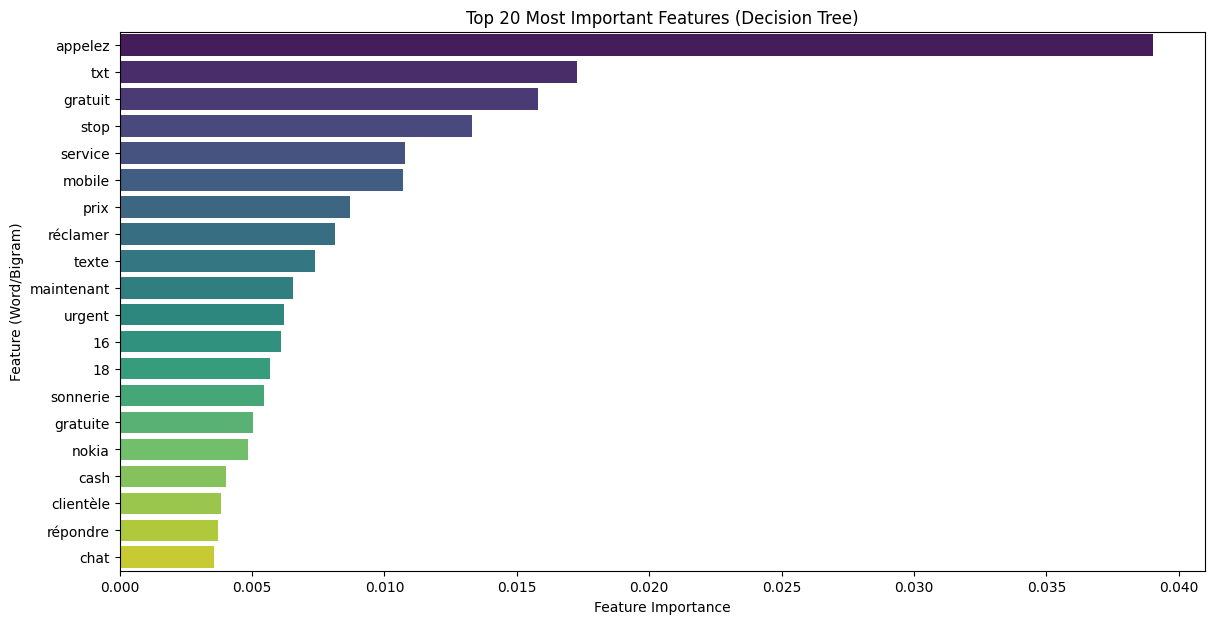

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(x='importance', y='feature', data=top_features_rf, palette='viridis', legend=False)
plt.title('Top 20 Most Important Features (Decision Tree)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature (Word/Bigram)')
plt.show()

In [ ]:
spam_detect_model_rf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
spam_detect_model_rf.fit(X_train_bigram, y_train_bigram)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

              precision    recall  f1-score   support

         ham       0.98      0.95      0.97       966
        spam       0.74      0.87      0.80       149

    accuracy                           0.94      1115
   macro avg       0.86      0.91      0.88      1115
weighted avg       0.95      0.94      0.94      1115



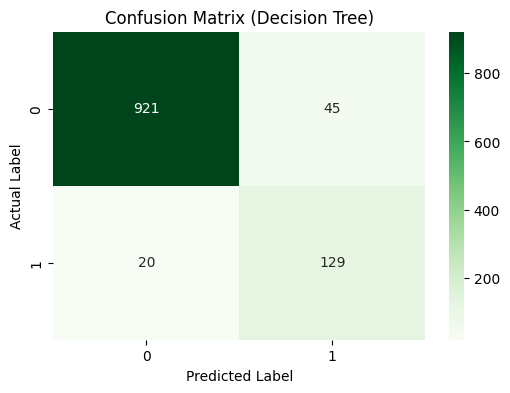

In [ ]:
predictions_rf = spam_detect_model_rf.predict(X_test_bigram)

print(classification_report(y_test_bigram, predictions_rf))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_bigram, predictions_rf), annot=True, fmt='d', cmap='Greens')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

In [ ]:
input_message_rf_1 = ["Veuillez appeler immédiatement le 08712402779 car un message urgent vous attend.."]
input_vector_rf_1 = bow_transformer_bigram.transform(input_message_rf_1)
prediction_rf_1 = spam_detect_model_rf.predict(input_vector_rf_1)
print(f"Test message: '{input_message_rf_1[0]}'")
print(f"Prediction (Random Forest): {prediction_rf_1[0]}")

input_message_rf_2 = ["SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE."]
input_vector_rf_2 = bow_transformer_bigram.transform(input_message_rf_2)
prediction_rf_2 = spam_detect_model_rf.predict(input_vector_rf_2)
print(f"Test message: '{input_message_rf_2[0]}'")
print(f"Prediction (Random Forest): {prediction_rf_2[0]}")

Test message: 'Veuillez appeler immédiatement le 08712402779 car un message urgent vous attend..'
Prediction (Random Forest): spam
Test message: 'SÉRIEUSEMENT. DITES-LUI CES MOTS EXACTS TOUT DE SUITE.'
Prediction (Random Forest): ham


In [ ]:
feature_names = bow_transformer_bigram.get_feature_names_out()
ham_prob = spam_detect_model_bigram.feature_log_prob_[0]
spam_prob = spam_detect_model_bigram.feature_log_prob_[1]


features_df = pd.DataFrame({
    'feature': feature_names,
    'ham_log_prob': ham_prob,
    'spam_log_prob': spam_prob
})

features_df['log_prob_diff'] = features_df['spam_log_prob'] - features_df['ham_log_prob']

top_spam_features = features_df.sort_values(by='log_prob_diff', ascending=False).head(20)

top_ham_features = features_df.sort_values(by='log_prob_diff', ascending=True).head(20)

print("\n--- Top 20 features most indicative of SPAM ---")
display(top_spam_features[['feature', 'log_prob_diff']])

print("\n--- Top 20 features most indicative of HAM ---")
display(top_ham_features[['feature', 'log_prob_diff']])


--- Top 20 features most indicative of SPAM ---


,feature,log_prob_diff
4428,appelez,4.520287
42854,urgent,4.339148
7951,cash,4.152562
35874,réclamer,4.152562
38986,stop,4.099918
35854,réclamation,3.856296
45786,£1000,3.821205
45841,£2000,3.784837
836,150ppm,3.747097
7240,box,3.747097



--- Top 20 features most indicative of HAM ---


,feature,log_prob_diff
24004,ltgt,-4.876976
45973,ça,-4.799267
43153,vais,-4.640899
31045,peux,-4.370812
46461,ü,-4.281684
31741,plus tard,-4.164960
9129,chose,-4.135973
8207,cest bon,-3.965347
41809,très,-3.941817
23819,lor,-3.941817


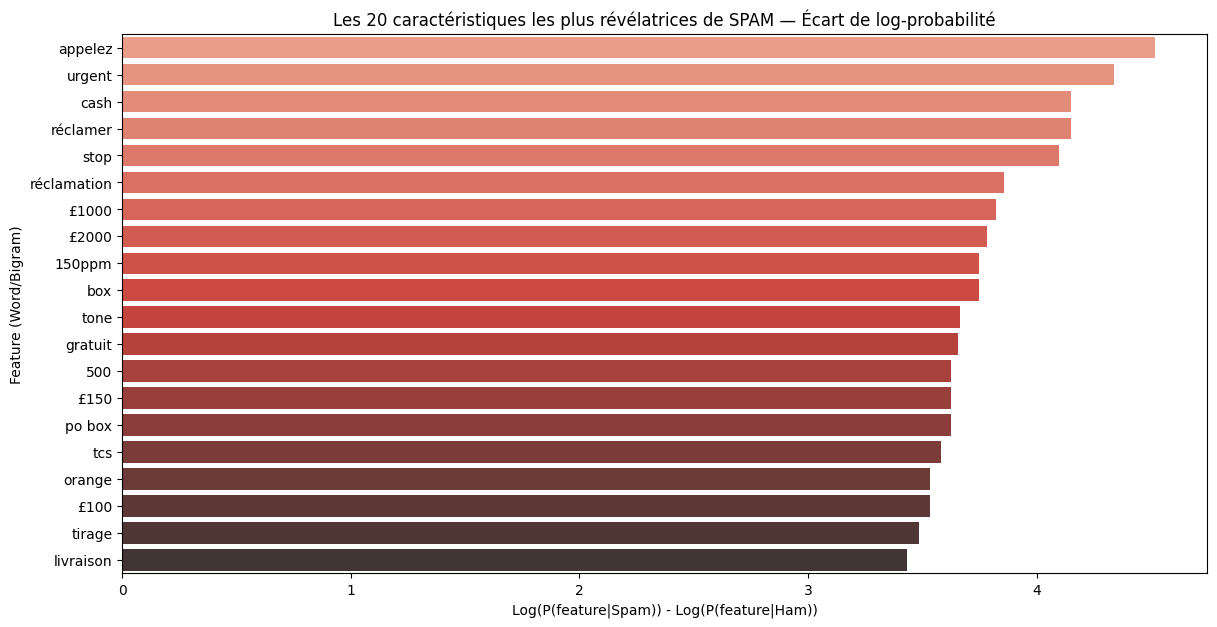

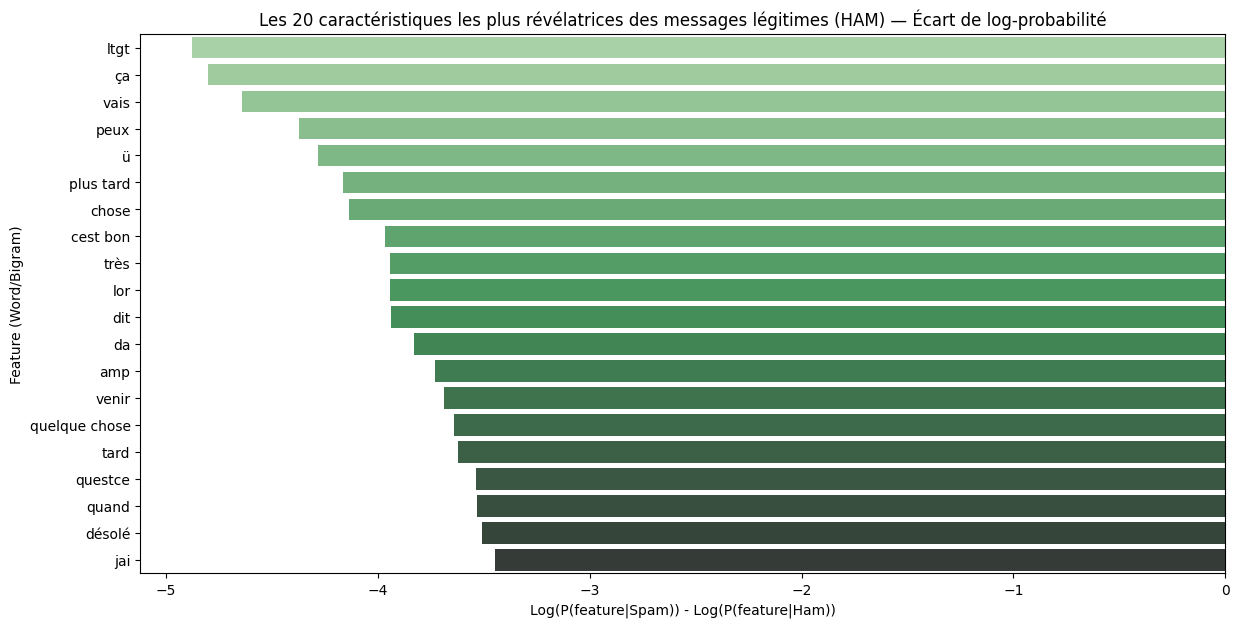

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(x='log_prob_diff', y='feature', data=top_spam_features, palette='Reds_d', legend=False)
plt.title('Les 20 caractéristiques les plus révélatrices de SPAM — Écart de log-probabilité')
plt.xlabel('Log(P(feature|Spam)) - Log(P(feature|Ham))')
plt.ylabel('Feature (Word/Bigram)')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='log_prob_diff', y='feature', data=top_ham_features, palette='Greens_d', legend=False)
plt.title('Les 20 caractéristiques les plus révélatrices des messages légitimes (HAM) — Écart de log-probabilité')
plt.xlabel('Log(P(feature|Spam)) - Log(P(feature|Ham))')
plt.ylabel('Feature (Word/Bigram)')
plt.show()


In [36]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier

# Save the unigram CountVectorizer
joblib.dump(bow_transformer, 'bow_transformer_unigram.pkl')
print("Saved bow_transformer as bow_transformer_unigram.pkl")

# Save the unigram Multinomial Naive Bayes model
joblib.dump(spam_detect_model, 'spam_detect_model_unigram.pkl')
print("Saved spam_detect_model (unigram MNB) as spam_detect_model_unigram.pkl")

# Save the bigram CountVectorizer
joblib.dump(bow_transformer_bigram, 'bow_transformer_bigram.pkl')
print("Saved bow_transformer_bigram as bow_transformer_bigram.pkl")

# Save the bigram Multinomial Naive Bayes model
joblib.dump(spam_detect_model_bigram, 'spam_detect_model_bigram_mnb.pkl')
print("Saved spam_detect_model_bigram (bigram MNB) as spam_detect_model_bigram_mnb.pkl")

# Re-create and save the bigram Random Forest model
# This ensures the Random Forest model is explicitly defined and saved as intended,
# especially if 'spam_detect_model_rf' was overwritten or not in memory.
spam_detect_model_rf_for_saving = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
spam_detect_model_rf_for_saving.fit(X_train_bigram, y_train_bigram) # Re-fit the RF model
joblib.dump(spam_detect_model_rf_for_saving, 'spam_detect_model_bigram_rf.pkl')
print("Saved bigram Random Forest model as spam_detect_model_bigram_rf.pkl")

# Re-create and save the bigram Decision Tree model
# This ensures the Decision Tree model is explicitly defined and saved as intended.
spam_detect_model_dt = DecisionTreeClassifier(random_state=42)
spam_detect_model_dt.fit(X_train_bigram, y_train_bigram)
joblib.dump(spam_detect_model_dt, 'spam_detect_model_bigram_dt.pkl')
print("Saved spam_detect_model_dt (bigram DT) as spam_detect_model_bigram_dt.pkl")

Saved bow_transformer as bow_transformer_unigram.pkl
Saved spam_detect_model (unigram MNB) as spam_detect_model_unigram.pkl
Saved bow_transformer_bigram as bow_transformer_bigram.pkl
Saved spam_detect_model_bigram (bigram MNB) as spam_detect_model_bigram_mnb.pkl
Saved bigram Random Forest model as spam_detect_model_bigram_rf.pkl
Saved spam_detect_model_dt (bigram DT) as spam_detect_model_bigram_dt.pkl


In [37]:
from google.colab import files

files.download('spam_detect_model_unigram.pkl')
files.download('bow_transformer_unigram.pkl')
files.download('spam_detect_model_bigram_mnb.pkl')
files.download('bow_transformer_bigram.pkl')
files.download('spam_detect_model_bigram_rf.pkl')
files.download('spam_detect_model_bigram_dt.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>